# Supporting Information

The following section provides specific examples of generative BigSMILES to demonstrate how various polymer ensembles might be created. This is an interactive Jupyter notebook that generates visual representations of polymeric ensembles automatically using the [reference implementation](https://github.com/InnocentBug/bigSMILESgen) of generative BigSMILES. Visual representations of polymers can become complex for long-chain molecules, hence we typically restrict ourselves to a manageable length.

## Preliminary Code for Visualization

This section includes Python code that converts generative BigSMILES into visual representations suitable for a Jupyter notebook. While not essential for understanding the main text, it can serve as a reference for how to use the reference implementation.

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
pydot = None
try:
    import pydot
except:
    pass
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import gbigsmiles
from gbigsmiles import System, mol_prob, Molecule, System

# Consistent random numbers also across calls
rng = np.random.default_rng(42)


def render_svg(svg):
    """Render SVG images in the Notebook"""
    try:
        svg_string = svg.decode("utf-8")
    except AttributeError:
        svg_string = svg
    svg_string = svg_string.replace("svg:", "")
    return SVG(svg_string)


def moltosvg(mol, molSize=(450, 150), kekulize=False):
    """Generate a SVG stick representation of molecule."""
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg


def draw_molecule(molecule_string):
    global rng
    # Generate the abstract python object, parsing bigSMILES
    # Try it as a system first
    bigSMILESmol = System(molecule_string)
    mol = bigSMILESmol.generate(rng=rng)
    return render_svg(moltosvg(mol.mol))


def draw_generation_graph(molecule_string):
    bigSMILESmol = Molecule(molecule_string)
    graph = bigSMILESmol.gen_reaction_graph()
    graph_dot = gbigsmiles.reaction_graph_to_dot_string(graph, bigSMILESmol)
    if pydot:
        pydot_graph = pydot.graph_from_dot_data(graph_dot)[0]
        graph_svg = pydot_graph.create_svg()
        return render_svg(graph_svg)
    else:
        return ''


## Case Study: PS and PMMA

Polystyrene (PS) and polymethyl methacrylate (PMMA) are two well-known and widely studied polymers. We'll use them as examples to demonstrate different concepts of how generative BigSMILES can be employed to create various ensembles.

To begin with, let's consider the standard BigSMILES notation for PS and PMMA repeat units:
`CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1[<], [>][<]CC([>])C(=O)OC [<]}[Br]`

In common terms, this represents the random copolymer PS-r-PMMA. Technically, this BigSMILES notation covers all subsequent examples, and we'll show how generative BigSMILES can be used to distinguish between different polymer ensembles.

## PS-r-PMMA with Molecular Weight Distribution

Our first step is to specify the molecular weight distribution. We'll use the Schulz-Zimm distribution as an example, with a molecular weight average (Mw) of 1500 and a number average molecular weight (Mn) of 1400.

In [2]:
# Define a generative bigSMILES string representing an ensemble of molecules
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1, [<]CC([>])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br].|5e5|"

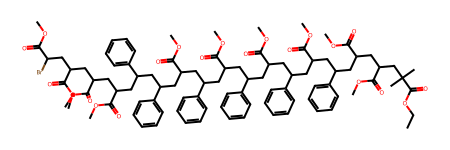

In [3]:
# Visualize the generated molecule
draw_molecule(generative_bigSMILES)

To better understand the composition of our ensemble, let's visualize its generative graph:

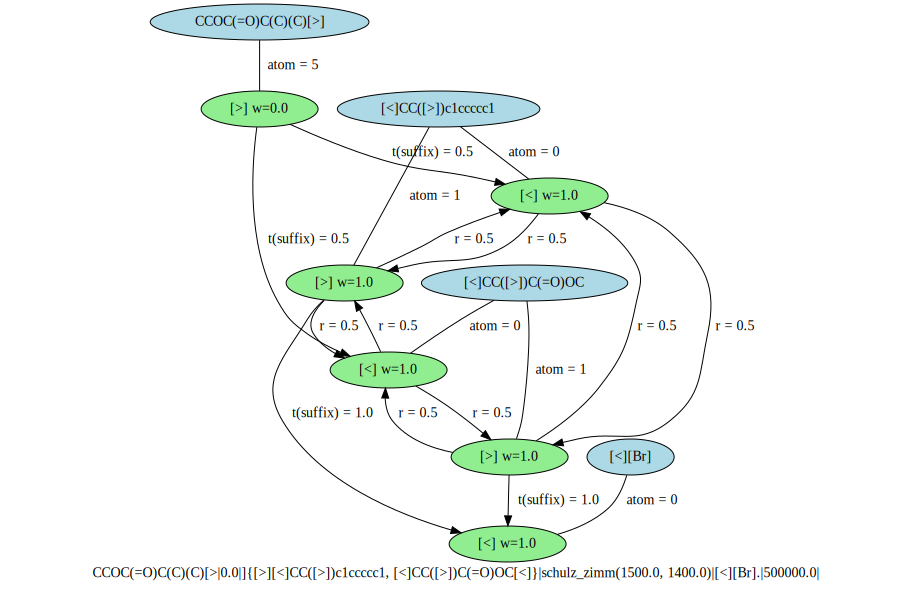

In [4]:
# Draw the generative graph of the ensemble
draw_generation_graph(generative_bigSMILES)

In the observed molecule, Polystyrene (PS) and Poly(methyl methacrylate) (PMMA) seem to be equally distributed. This is anticipated since we use default values, assigning equal weights to all bond descriptors. To validate this observation, we compute the precise ratio across an ensemble of molecules.

In [5]:
import rdkit
from rdkit.Chem import rdMolDescriptors as rdDescriptors
from IPython.display import clear_output
import platform
IS_LINUX = "linux" in platform.system().lower()
import os
TESTING_ENV_str = os.environ.get("TESTING_ENV", "False")

if TESTING_ENV_str in ("true", "True", "ON"):
    TESTING_ENV=True
if TESTING_ENV_str in ("false", "False", "OFF"):
    TESTING_ENV=False

# Just a little helper function to show the progress interactively
def update_progress(progress):
    bar_length = 20
    block = int(round(bar_length * progress))
    if not TESTING_ENV:
        clear_output(wait = True)
        text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
        print(text)
    
def count_PS_PMMA_monomers(gen_mol):
    # Since the =O is unique to the PMMA and head group we can count the '=' in the smiles string to determine the number of PMMA.
    n_PMMA = gen_mol.smiles.count("=")
    # subtract the head group double bond
    n_PMMA -= 1

    # Only PS has exactly one aromatic ring, so we can determine the number of PS monomers
    n_PS = rdDescriptors.CalcNumAromaticCarbocycles(gen_mol.mol)

    return n_PMMA, n_PS

# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    # Use a full ensemble system determine the ration of PS to PMMA
    system = gbigsmiles.System(generative_bigSMILES)
    total_PMMA = 0
    total_PS = 0
    total_weight = 0
    # Iterate the molecules of a full system
    for gen_mol in system.generator:
        n_PMMA, n_PS = count_PS_PMMA_monomers(gen_mol)
        total_PMMA += n_PMMA
        total_PS += n_PS
        total_weight += gen_mol.weight
        update_progress(total_weight/system.system_mass)
    
    ratio = total_PMMA/(total_PS + total_PMMA)
    print(ratio, total_PMMA, total_PS)
    expected_ratio = 0.5
    print(ratio, expected_ratio)
    # For automated tests we raise an exception for unexpected deviations
    if np.abs(expected_ratio - ratio) > 0.02:
        raise RuntimeError(f"Unexpected deviation of the monomer composition by more then 2%: {(ratio, expected_ratio)}")

Progress: [####################] 100.2%
0.49275649930541776 2483 2556
0.49275649930541776 0.5


We've confirmed an equal ratio between the two monomers in the entire ensemble. Our subsequent task is to modify this composition using bond descriptor weights.

## Adjusting the PS to PMMA Ratio to 80:20

By assigning varied weights to the bond descriptors, we can change the composition of PS and PMMA.

In [6]:
# Define a generative bigSMILES string with weighted bond descriptors
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|8|]CC([>|8|])c1ccccc1, [<|2|]CC([>|2|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br].|5e5|"

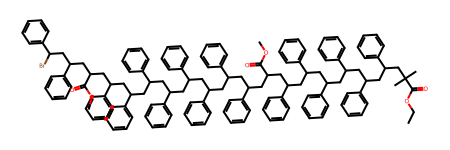

In [7]:
# Visualize the new generated molecule
draw_molecule(generative_bigSMILES)

The changes are noticeable, with PS now being the majority monomer and PMMA reduced to a minority. The generative graph will reflect this change, particularly in the transition rates `r` between bond descriptors for the two monomers.

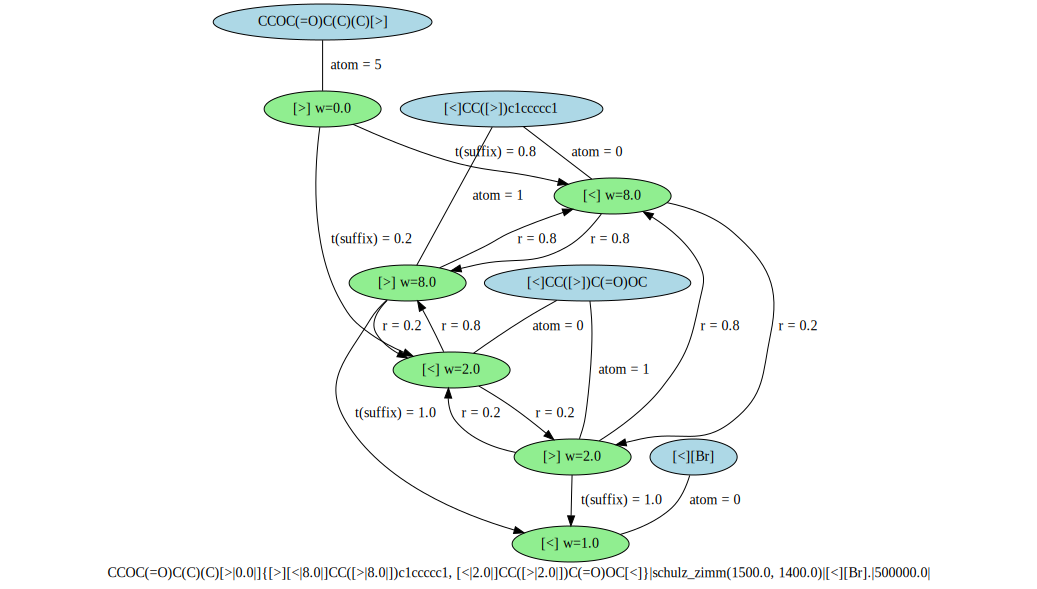

In [8]:
# Draw the generative graph for the modified ensemble
draw_generation_graph(generative_bigSMILES)

In [9]:
# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    # Use a full ensemble system determine the ration of PS to PMMA
    system = gbigsmiles.System(generative_bigSMILES)
    total_PMMA = 0
    total_PS = 0
    total_weight = 0
    # Iterate the molecules of a full system
    for gen_mol in system.generator:
        n_PMMA, n_PS = count_PS_PMMA_monomers(gen_mol)
        total_PMMA += n_PMMA
        total_PS += n_PS
        total_weight += gen_mol.weight
        update_progress(total_weight/system.system_mass)

    ratio = total_PMMA/(total_PS+total_PMMA)
    expected_ratio = 0.2
    # For automated tests we raise an exception for unexpected deviations
    if np.abs(expected_ratio - ratio) > 0.05:
        raise RuntimeError(f"Unexpected deviation of the monomer composition by more then 5%: {(ratio, expected_ratio)}")

Progress: [####################] 100.0%


This confirms that we have achieved the desired monomer composition in the ensemble.

## Modifying PS-r-PMMA blockiness to 70% with a 50:50 ratio

In the previous example, we adjusted the ratio of PS to PMMA but didn't specify the blockiness, or the likelihood that a given monomer is followed by the same type. By using list weight notation in our generative bigSMILES string, we can set the transition probabilities for PS to PS and PMMA to PMMA.

For instance, let's set the transition probability for both PS -> PS and PMMA -> PMMA to 70%, yielding a noticeably blockier random copolymer. We can accomplish this by assigning weights of 7 and 3 to the respective transitions between the monomers.

In [10]:
# Define a generative bigSMILES string with adjusted blockiness
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 3 0 7|]CC([>|3 0 7 0|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br].|5e5|"

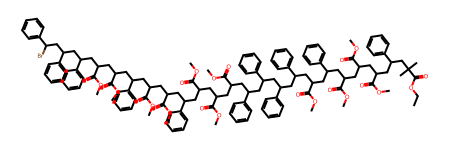

In [11]:
# Visualize the blockier molecule
draw_molecule(generative_bigSMILES)

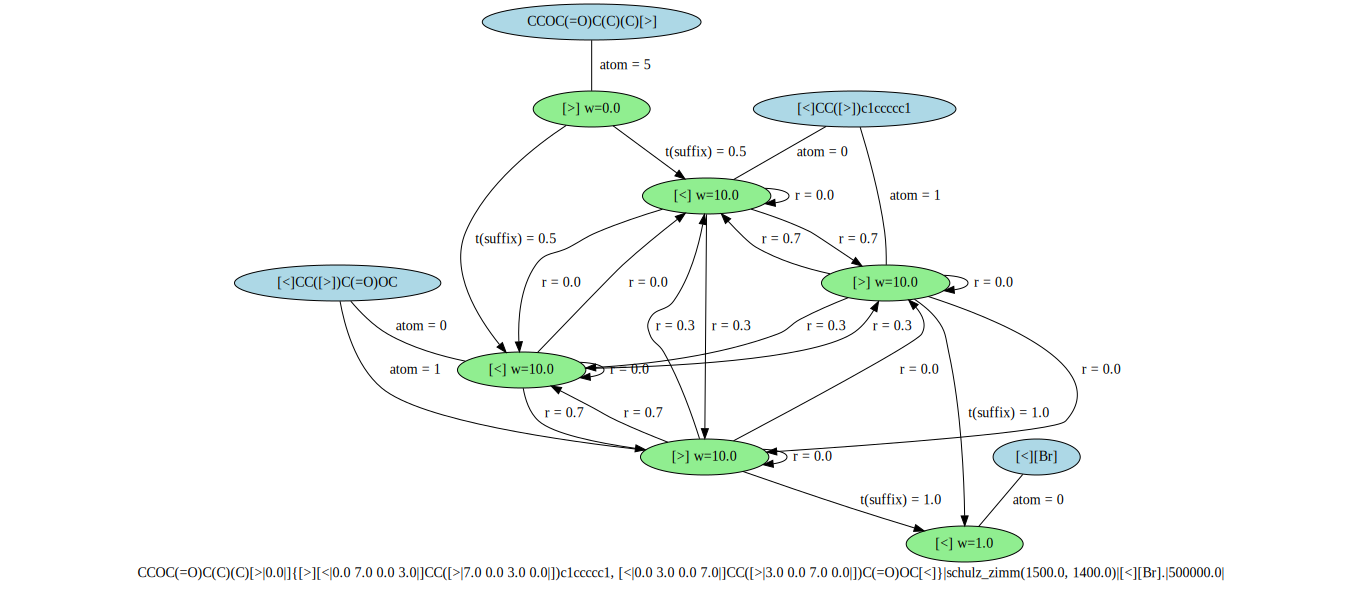

In [12]:
# Draw the generative graph for the blockier ensemble
draw_generation_graph(generative_bigSMILES)

In [13]:
# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    # Use a full ensemble system determine the ration of PS to PMMA
    system = gbigsmiles.System(generative_bigSMILES)
    total_PMMA = 0
    total_PS = 0
    total_weight = 0
    # Iterate the molecules of a full system
    for gen_mol in system.generator:
        n_PMMA, n_PS = count_PS_PMMA_monomers(gen_mol)
        total_PMMA += n_PMMA
        total_PS += n_PS
        total_weight += gen_mol.weight
        update_progress(total_weight/system.system_mass)

    ratio = total_PMMA/(total_PS + total_PMMA)
    expected_ratio = 0.5
    print(ratio, expected_ratio)
    # For automated tests we raise an exception for unexpected deviations
    if np.abs(expected_ratio - ratio) > 0.05:
        raise RuntimeError(f"Unexpected deviation of the monomer composition by more then 5%: {(ratio, expected_ratio)}")

Progress: [####################] 100.2%
0.5097029702970297 0.5


This demonstrates that, despite altering blockiness, we can consistently control the monomer composition as intended. The generative graph illustrates how transition probabilities now lean more towards staying within the same block than switching.

## Adjusting Blockiness: 70% for PS and 20% for PMMA

In our prior example, both blocks had a 30% transition probability into the other block, leading to an even 50% monomer ratio. By modifying the blockiness levels, we can further refine this composition.

For this iteration, we'll retain a 70% blockiness for Polystyrene (PS) and decrease the blockiness of Poly(methyl methacrylate) (PMMA) to 20%.

In [14]:
# Define a generative bigSMILES string with varied blockiness
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 8 0 2|]CC([>|8 0 2 0|])C(=O)OC [<]}|schulz_zimm(2500, 2400)|[Br].|5e5|"

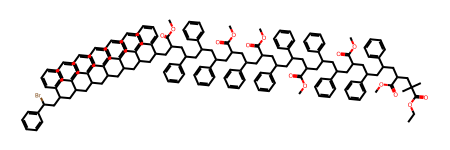

In [15]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

In the generated molecule, you can see that PS remains blocky, but it is now interspersed with less blocky PMMA monomers. The ratio between the monomers can be estimated by comparing the probabilities to stay within the same block, which yields approximately 0.286.

The generative graph should also accurately represent these transition probabilities.

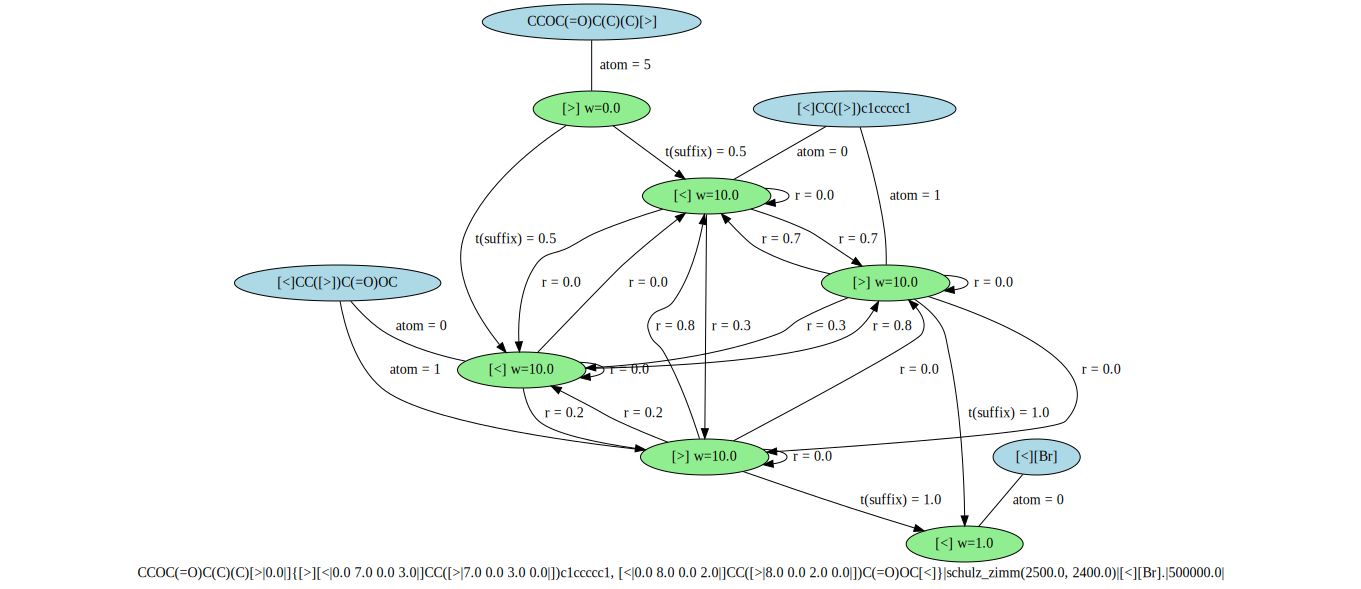

In [16]:
# Draw the generative graph for the blockier ensemble
draw_generation_graph(generative_bigSMILES)

## PS-r-PMMA in an alternating sequence (least blocky)

One way to minimize blockiness is by creating an alternating sequence of monomers. This can be represented with identical bond descriptors in the regular BigSMILES notation. For example, the string `CCOC(=O)C(C)(C){[>2][<1]CC([>2])c1ccccc1, [<2]CC([>1])C(=O)OC ; [<1][Br], [<2][Br] []}` specifies that each monomer can only bond with the other monomer type and not with itself, resulting in an alternating sequence.

This limitation is represented by using stochastic end groups with both bond descriptors, as the molecule can end in either PS or PMMA and both need to be terminable. However, this prevents continuation of the molecule after the stochastic object.

To overcome this limitation in generative BigSMILES, we can use listed bond weights instead. This allows all bond descriptors to be compatible while defining zero transition probabilities for unwanted connections.

In [17]:
# Define a generative bigSMILES string with zero transition probabilities for unwanted connections
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|0 0 0 1|]CC([>|0 0 1 0|])c1ccccc1, [<|0 1 0 0|]CC([>|1 0 0 0|])C(=O)OC [<]}|schulz_zimm(1000, 900)|[Br]"

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


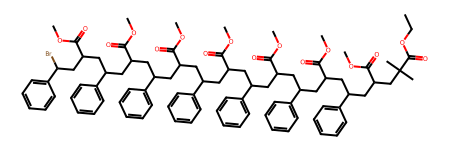

In [18]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

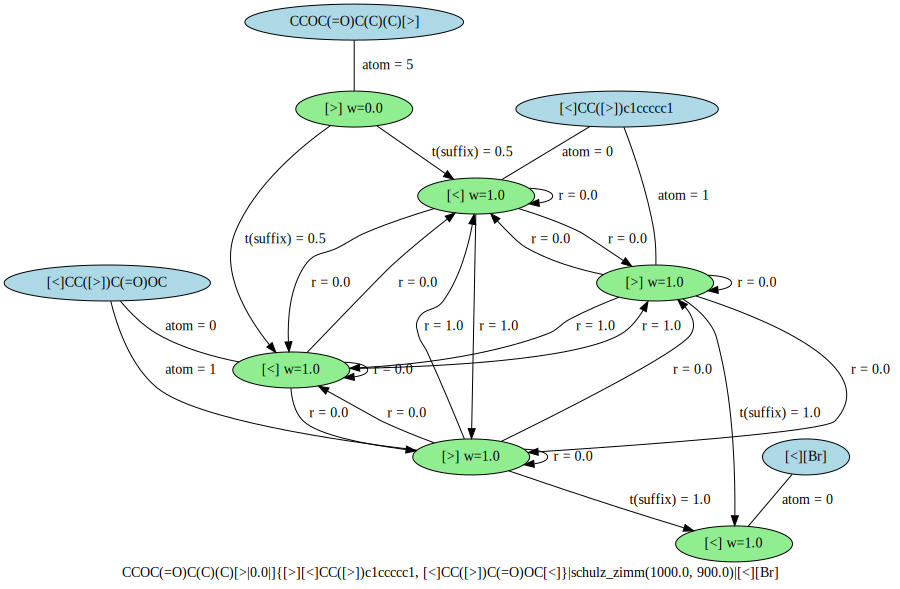

In [19]:
# Draw the generative graph for the alternating ensemble
draw_generation_graph(generative_bigSMILES)

As seen in the generative graph and the generated molecule, the ensemble now follows an alternating sequence. Moreover, the use of listed bond weights allows for potential continuation as it does not require stochastic end groups.

## PS-b-PMMA Diblock Copolymer

At the other end of the spectrum is the diblock copolymer. While the original BigSMILES notation correctly describes diblock copolymers, a more explicit representation employs two connected stochastic objects, as seen in the string `CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1 [<]}{[>][<]CC([>])C(=O)OC[<]}[Br]`.

The same notation can be applied within the generative BigSMILES:

In [20]:
# Define a generative bigSMILES string for a diblock copolymer
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(1000,900)|{[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(1000, 900)|[Br]"

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


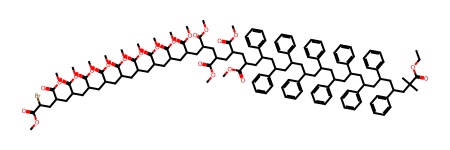

In [21]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

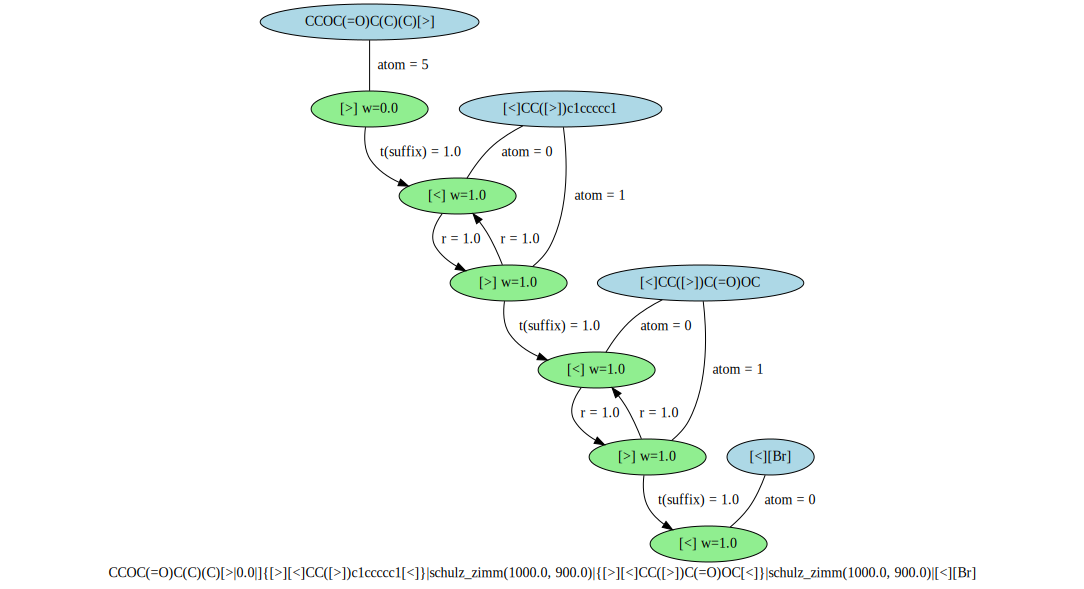

In [22]:
# Draw the generative graph for the diblock copolymer
draw_generation_graph(generative_bigSMILES)

In the BigSMILES notation, the ratio between the two blocks remains unspecified. However, with generative BigSMILES, you can specify the size of the two blocks via the molecular weight specification for each stochastic object.

## PS and PMMA Homopolymer Mixtures

The original BigSMILES notation also encompasses polymer ensembles of PS and PMMA homopolymers, and mixtures of the two, although it's recommended to avoid describing the homopolymers in this way.

There exists a BigSMILES variant that can depict a mixture of PS and PMMA homopolymers:

`{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1], CC(C)[>2], [<1][Br], [<2][Br][]}`

In this variant, all bond descriptors between PS or PMMA are incompatible, preventing connections between PS and PMMA monomers or end groups. As a result, this notation uniquely identifies a mixture of PS and PMMA homopolymers. However, using this notation to depict a mixture is strongly discouraged.

This characteristic of the notation can be utilized in generative BigSMILES as well:

In [23]:
# Define a generative bigSMILES string for a mixture of PS and PMMA homopolymers
generative_bigSMILES = "{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1|2|], CC(C)[>2], [<1|2|][Br], [<2][Br][]}|schulz_zimm(700, 600)|"

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


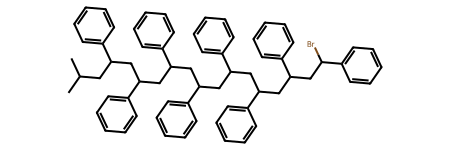

In [24]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

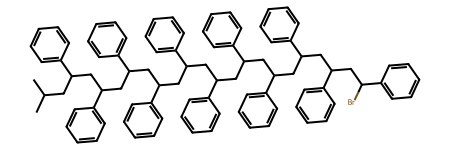

In [25]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

Note how the various homopolymers are generated from a single BigSMILES string. We've used the weight of the end groups to achieve a 2:1 ratio between PS and PMMA.

The generative graph clearly illustrates how the two types of molecules are separate from one another:

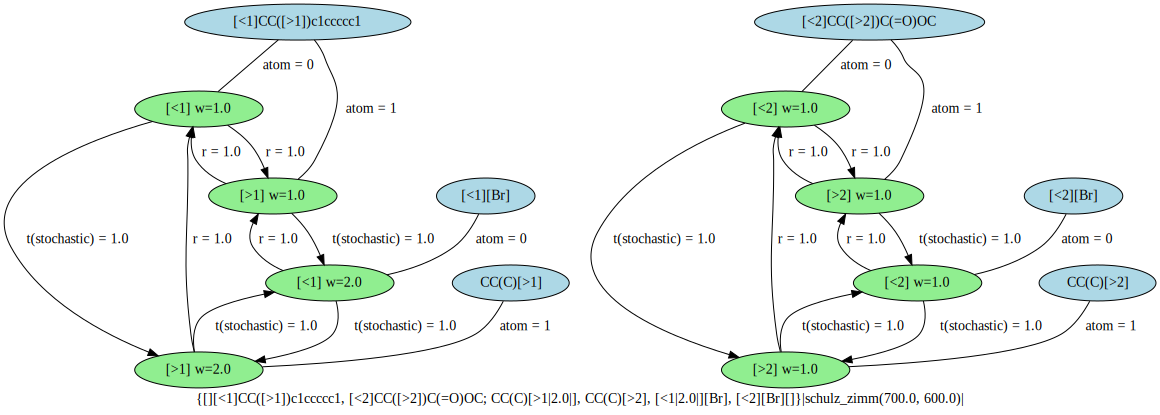

In [26]:
# Draw the generative graph for the mixture of homopolymers
draw_generation_graph(generative_bigSMILES)

Despite this functionality, using this notation

to describe a mixture of homopolymers remains inadvisable. Instead, use the mixture notation of generative BigSMILES, which offers finer control over the resulting ensembles and more accurately conveys the intent:

In [27]:
# Define a generative bigSMILES string for a more explicit mixture of PS and PMMA homopolymers
generative_bigSMILES = "CC(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(700, 600)|[Br].|5000|CC(C){[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(700, 600)|[Br].|1500|"

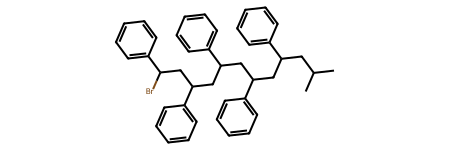

In [28]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

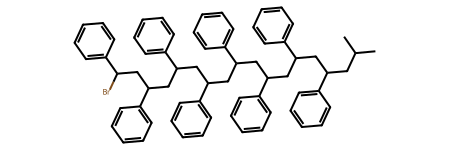

In [29]:
draw_molecule(generative_bigSMILES)

The enhanced notation, strongly recommended for mixtures, leads to the same molecular ensemble but is more straightforward and doesn't necessitate single stochastic object notation for mixtures.

This applies universally to mixtures such as polymers in solution, even though we're showcasing a mixture of two homopolymers here.

## Polymer Tacticity with Generative BigSMILES

Polymer tacticity is an essential aspect that significantly influences their properties. We'll delve into some examples to understand this concept better using generative BigSMILES notation.

### Atactic Polypropylene (PP)

For atactic polymers, there is no need to explicitly mention tacticity.

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


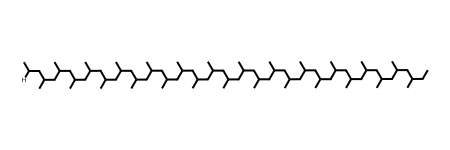

In [30]:
generative_bigSMILES = "C{[>][<]CC(C)[>][<]}|poisson(900)|[H]"
draw_molecule(generative_bigSMILES)

### Isotactic PP

To define isotactic PP, we have to explicitly mention the tacticity within the repeating monomer unit as shown:

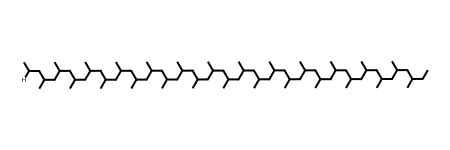

In [31]:
generative_bigSMILES = "C{[>][<]C[C@H](C)[>][<]}|poisson(900)|[H]"
draw_molecule(generative_bigSMILES)

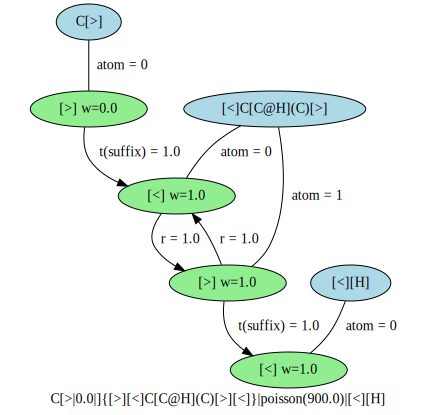

In [32]:
draw_generation_graph(generative_bigSMILES)

### Syndiotactic PP

In the case of syndiotactic PP, we establish two distinct repeat units, each with a unique tacticity. Then, we utilize the same method as with PS-PMMA to achieve alternating repetition of the repeat units.

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


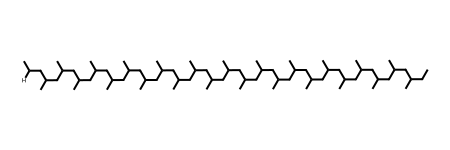

In [33]:
generative_bigSMILES = "C{[>][<|0 0 0 1|]C[C@H](C)[>|0 0 1 0|], [<|0 1 0 0|]C[C@@H](C)[>|1 0 0 0|] [<]}|poisson(900)|[H]"
draw_molecule(generative_bigSMILES)

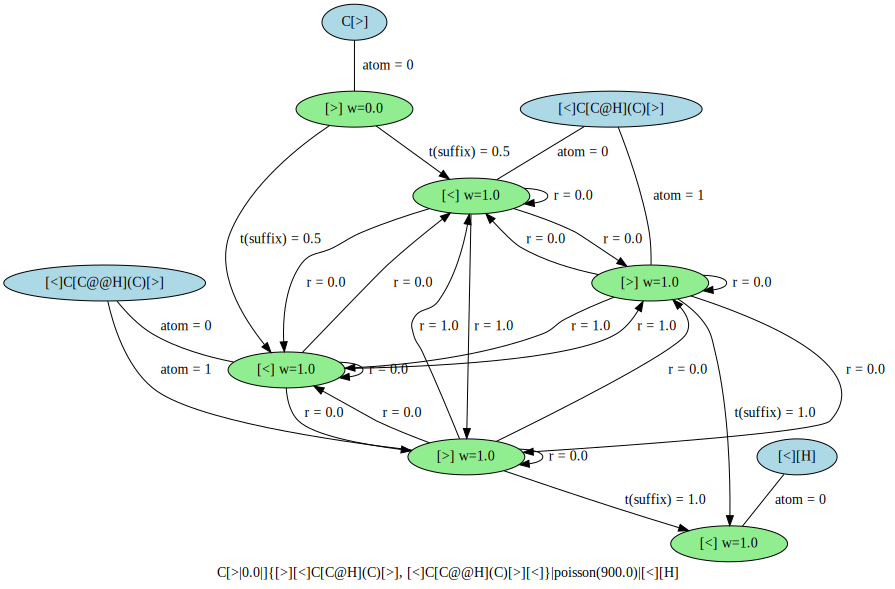

In [34]:
draw_generation_graph(generative_bigSMILES)

### Stereo Enriched PP

To create an atactic PP, but with enrichment of one of the stereochemistries, we utilize a similar approach as before. Instead of excluding specific transitions, we merely enhance the weight of the bond descriptors of the monomer we aim to enrich. In this example, the weight of the `C[C@H](C)` monomer is increased by 3.

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


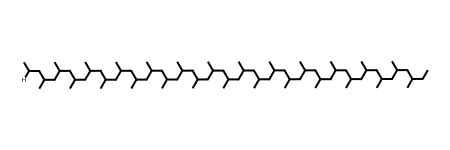

In [35]:
generative_bigSMILES = "C{[>][<|3|]C[C@H](C)[>|3|], [<]C[C@@H](C)[>] [<]}|poisson(900)|[H]"
draw_molecule(generative_bigSMILES)

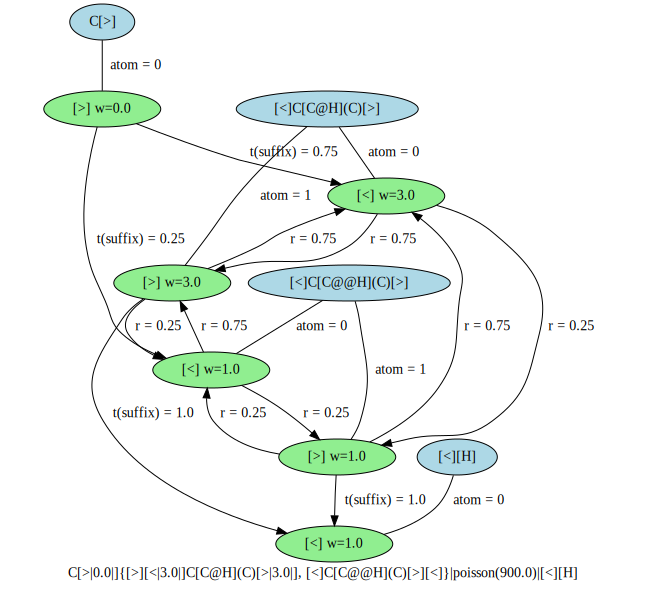

In [36]:
draw_generation_graph(generative_bigSMILES)

## Radical Polymerization with Recombination (Coupling)

During radical synthesis, a polymer might undergo a recombination process. To describe such a phenomenon, we typically use two blocks of stochastic objects. The first block represents the standard synthesis, while the second one, which is the reverse of the first, follows it. The reason it must be reversed is due to the synthesis process: both halves are synthesized first and then combined at the active center.

Consider the following example:


/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


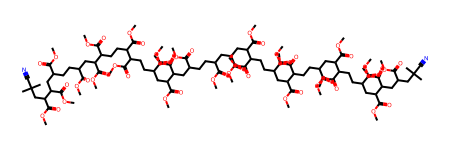

In [37]:
generative_bigSMILES = "N#CC(C)(C){[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|{[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|C(C)(C)C#N"
draw_molecule(generative_bigSMILES)

In this example, we assign the same molecular weight distribution to both halves. Moreover, note how the prefix of the first block is the reverse of the suffix of the second block.


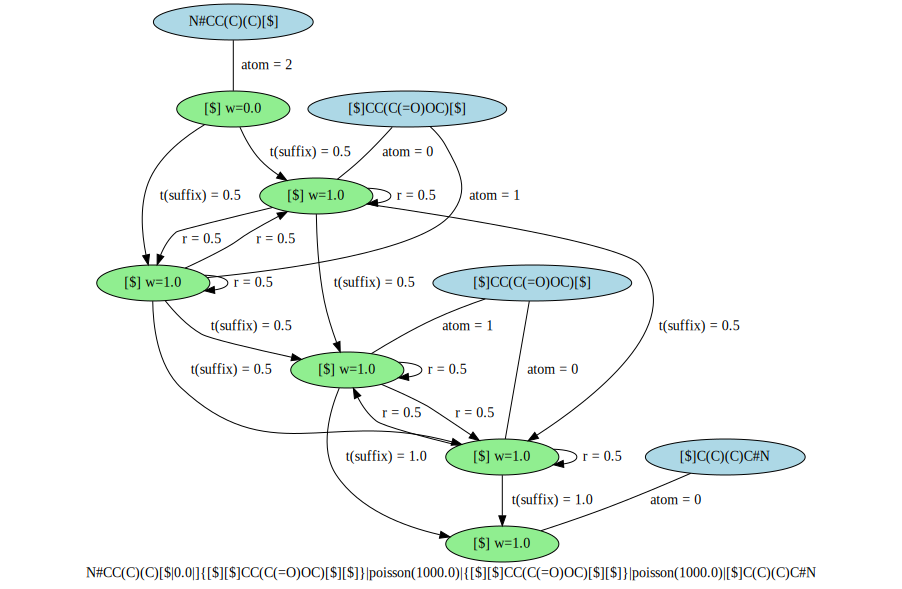

In [38]:
draw_generation_graph(generative_bigSMILES)

A realistic ensemble would comprise both recombined and non-recombined polymers. To depict this, we describe it as a mixture of both types, utilizing the mixture notation of generative BigSMILES. This approach also enables us to specify the ratio between the recombined and non-recombined polymers. For illustration, we'll use a 2:1 ratio here.


In [39]:
# Non-recombined polymer
generative_bigSMILES = "N#CC(C)(C){[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|[H]"
# Add the mixture component and specify the total molecular weight of non-recombined polymers
generative_bigSMILES += ".|1e4|"
# Add the recombined polymer
generative_bigSMILES += "N#CC(C)(C){[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|{[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|C(C)(C)C#N"
# Add the mixture notation, with half the molecular weight of this type of polymers
generative_bigSMILES += ".|5e3|"
print(generative_bigSMILES)

N#CC(C)(C){[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|[H].|1e4|N#CC(C)(C){[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|{[$][$]CC(C(=O)OC)[$][$]}|poisson(1000)|C(C)(C)C#N.|5e3|


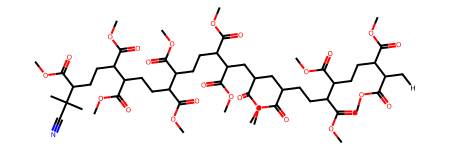

In [40]:
# Upon generating multiple molecules, we find some are recombined (larger with two `N#C` end groups), while others are non-recombined polymers with a hydrogen end group
draw_molecule(generative_bigSMILES)

We can repeat the `draw_molecule(generative_bigSMILES)` command to visualize different instances of polymer generation:


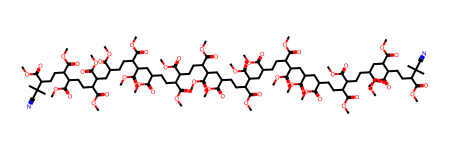

In [41]:
draw_molecule(generative_bigSMILES)

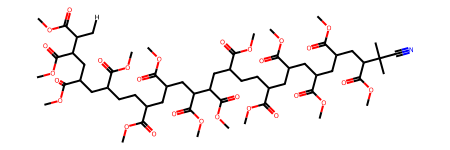

In [42]:
draw_molecule(generative_bigSMILES)

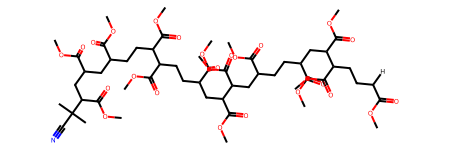

In [43]:
draw_molecule(generative_bigSMILES)

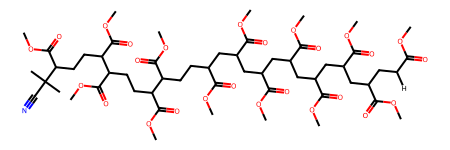

In [44]:
draw_molecule(generative_bigSMILES)

## Homopolymer: AA, BB Nylon 6,6

Nylon 6,6 constitutes two alternating repeat units in an AA,BB sequence. This can be effectively represented in BigSMILES using directed bond descriptors `[<], [>]`. Here's the corresponding representation:

`{[][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>];[>]O, [<][H][]}`

The same applies for generative BigSMILES. Once we incorporate a molecular weight distribution for step-growth polymerization, it enables the generation of realistic polymers.


/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


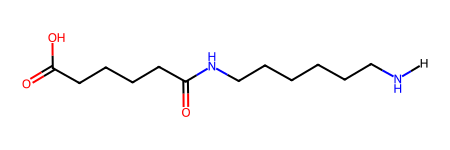

In [45]:
generative_bigSMILES = "{[][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>]; [<][H], [>]O []}|flory_schulz(4e-3)|"
draw_molecule(generative_bigSMILES)

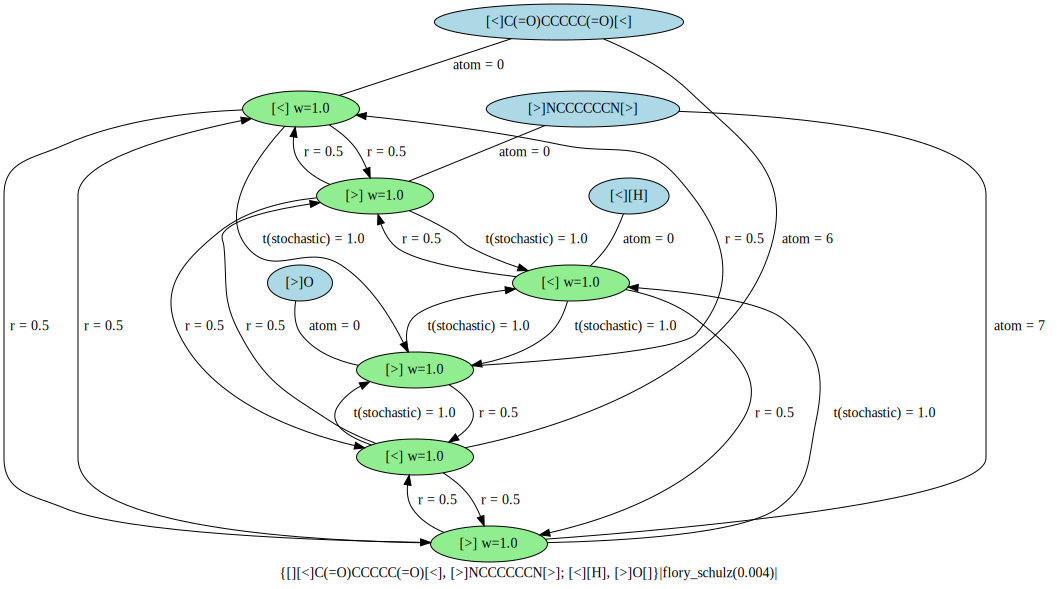

In [46]:
draw_generation_graph(generative_bigSMILES)

This authentic representation of Nylon 6,6 allows the generation to either conclude on an A unit `[<]C(=O)CCCCC(=O)[<]`, which is stochastically terminated with `[>]O`, or a B unit `[>]NCCCCCCN[>]` that ends with `[<][H]`. This is a typical scenario, which becomes evident as we generate more instances of the ensemble. However, to specify the repeat unit with which the generation should end, we need to delve deeper in the next section.

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


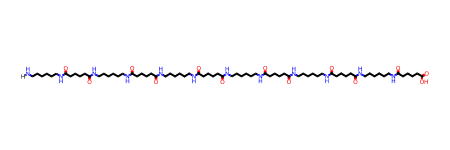

In [47]:
draw_molecule(generative_bigSMILES)

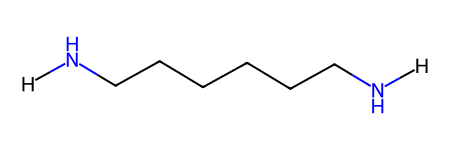

In [48]:
draw_molecule(generative_bigSMILES)

## Terminal Groups

As alluded to earlier, having advanced control over the terminal groups enables the description of diverse molecules. Transitioning from realistic Nylon 6,6 with two distinct stochastic endgroups to polyamide necessitates us to define explicitly the desired end group.

### Explicit: Polyamide

In BigSMILES, polyamide can be described as follows: `[H]O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>][<]}[H]`. With the appropriate terminal bond descriptor `[<]` oriented towards the left, this molecule must end with the B group `NCCCCCCN`.

A direct translation into generative BigSMILES isn't feasible here, since a stochastic generation could end with an A group. This situation could result in a missing corresponding end group to terminate the generation. Instead, we can define two possible end groups, with one adding a B unit prior to termination.

`[H]O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>]; [<][H], [>]NCCCCCCN[H] []}`


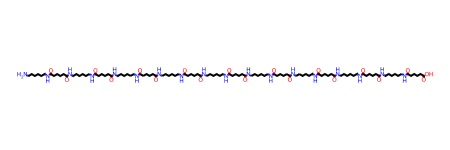

In [49]:
generative_bigSMILES = "O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>]; [<][H], [>]NCCCCCCN[H] []}|flory_schulz(1e-3)|"
draw_molecule(generative_bigSMILES)

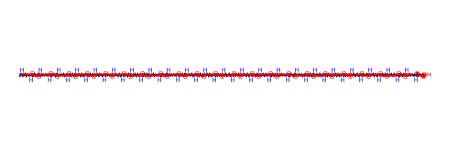

In [50]:
draw_molecule(generative_bigSMILES)

### Mixed

Stochastic end groups can also be applied in a mixed setting, where some sections of a stochastic object are terminated stochastically and others are terminated deterministically.

The bottlebrush from the primary manuscript serves as a perfect example of this scenario. Here, the arms are terminated with a stochastic end group `[H]`, while the backbone concludes with a bromine.

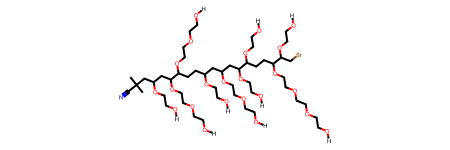

In [51]:
generative_bigSMILES = "N#CC(C)(C){[$] O([<|3|])(C([$])C[$]), [>]CCO[<|0 0 0 1 0 2|] ; [>][H] [$]}|poisson(900)|Br"
draw_molecule(generative_bigSMILES)

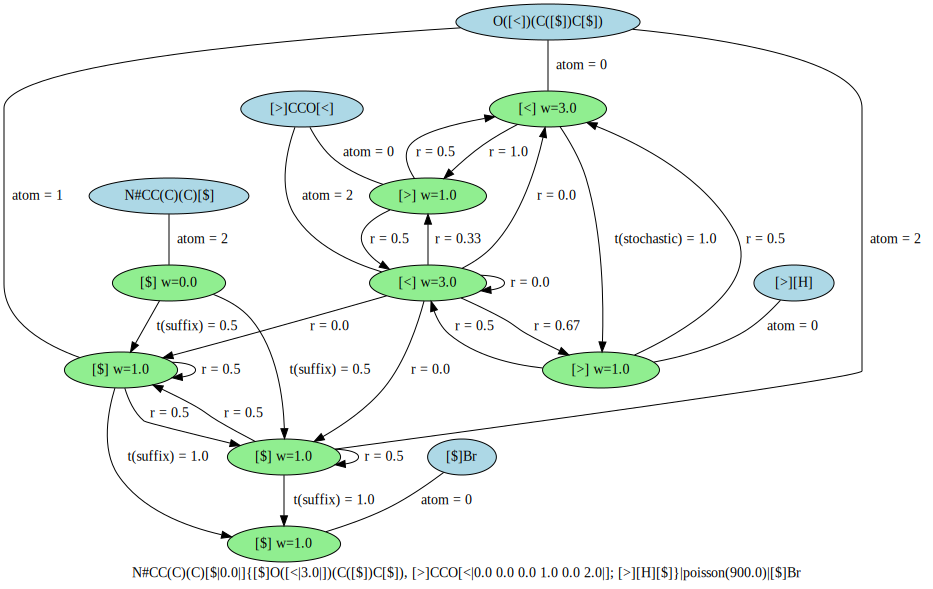

In [52]:
draw_generation_graph(generative_bigSMILES)

## Star Polymers

Star polymers are a unique class of polymers characterized by a central hub from which several arms extend outwards. A BigSMILES representation of a star polymer might look like this:

`OC({[$][$]CC[$][$]}[H])({[$][$]CC[$][$]}[H])({[$][$]CC[$][$]}[H])`

There are various approaches to represent star polymers in generative BigSMILES, which we will explore in the subsequent sections.

### Starting with a Central Hub to Grow Arms

A suitable starting point for generative BigSMILES of star polymers is the central connection point for the arms. In the given example, I am using a 3-arm polymer, so the central connecting element may appear as: `C(C[<])(C[<])(C[<])`. The three arms of the polymer can sprout from the three `[<]` bond descriptors.

We use a trick to ensure that the generation begins with this element by separating one atom (in this case `[H]`) from the initial carbon of the stochastic element and placing it as the prefix:

`[H]{[$] [$]C(C[<])(C[<])(C[<]) ...`

Here, the `[$]` bond descriptor is the right terminal bond descriptor and is only compatible with our initial central element.

#### Equal Length Arms

Next, we append the growth repeat units for the arms and add the terminal group for the arms to the stochastic element, ensuring each is only compatible with the other.

`[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}`

Now, we just need to add a molecular weight distribution. This distribution encompasses the length of the combined arms as they grow stochastically. The Gaussian distribution is a good fit for this task due to its linearity. By adding up the means and variances of the separate arms, we can achieve a Gaussian distribution for them. For example, let's assume we desire arms with an Mw of 200 and a variance of 50. Note that the arm length growth is entirely stochastic in this case.

`[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}|gauss(600, 150)|`


In [53]:
generative_bigSMILES = "[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}|gauss(600, 150)|"

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


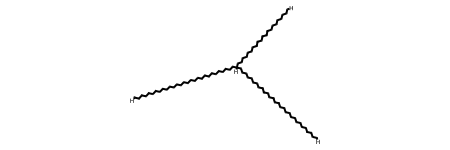

In [54]:
draw_molecule(generative_bigSMILES)

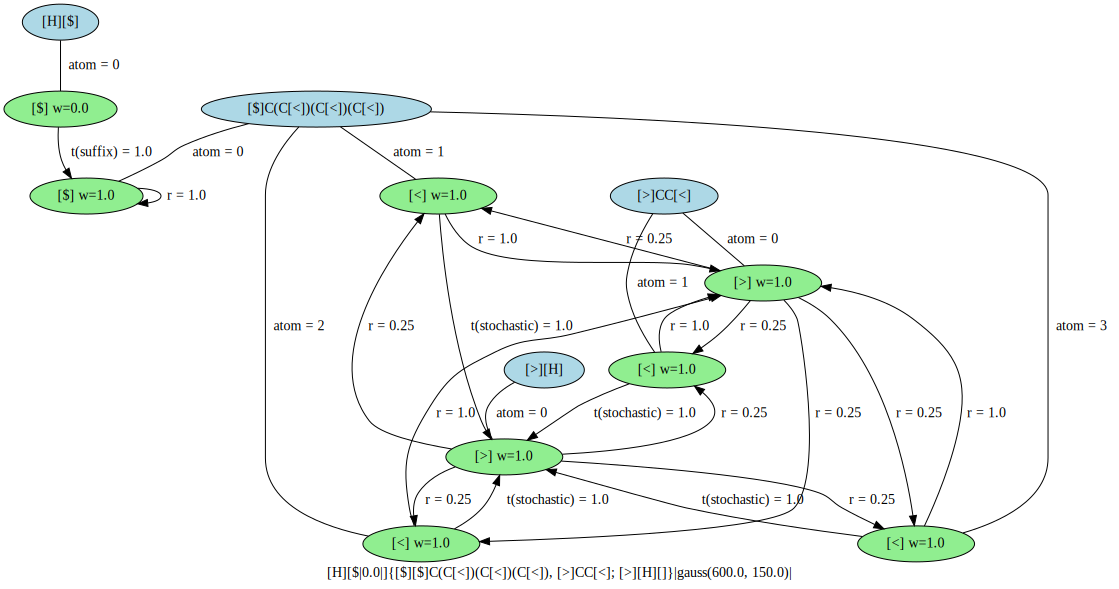

In [55]:
draw_generation_graph(generative_bigSMILES)

#### Non-equal Length Arms

In the case where the arms are not of equal length, we can describe this similarly to random copolymers by assigning different weights to different growth repeat units.

`[H]{[$] [$]C(C[<])(C[<])(C[<2]), [>]CC[<], [>2]CCO[<2]; [>][H], [>2][Si](C)(C)C []}|gauss(600, 150)|`

Here we utilize the third attachment point to affix a separate arm with a unique chemistry `[>2]OCO[<2]` and a unique end group for it `[>2]O`. It is noteworthy that it isn't necessary to have separate chemistries here, just different bond descriptors suffice.


/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


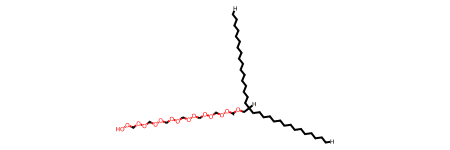

In [56]:
generative_bigSMILES = "[H]{[$][$]C(C[<])(C[<])(C[<2]), [>]CC[<], [>2]OCO[<2]; [>][H], [>2]O []}|gauss(600, 150)|"
draw_molecule(generative_bigSMILES)

Next, we can assign different weights to this special arm, making it shorter or longer relative to the other arms. Here we increase the weight from the default `|1|` to `|2|`, thus making it twice as likely to grow the second arm.


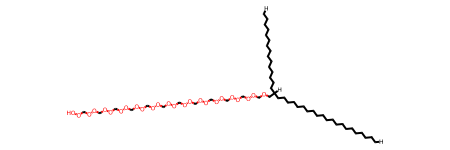

In [57]:
generative_bigSMILES = "[H]{[$] [$]C(C[<])(C[<])(C[<2|2|]), [>]CC[<], [>2|2|]OCO[<2|2|]; [>][H], [>2]O []}|gauss(800, 200)|"
draw_molecule(generative_bigSMILES)

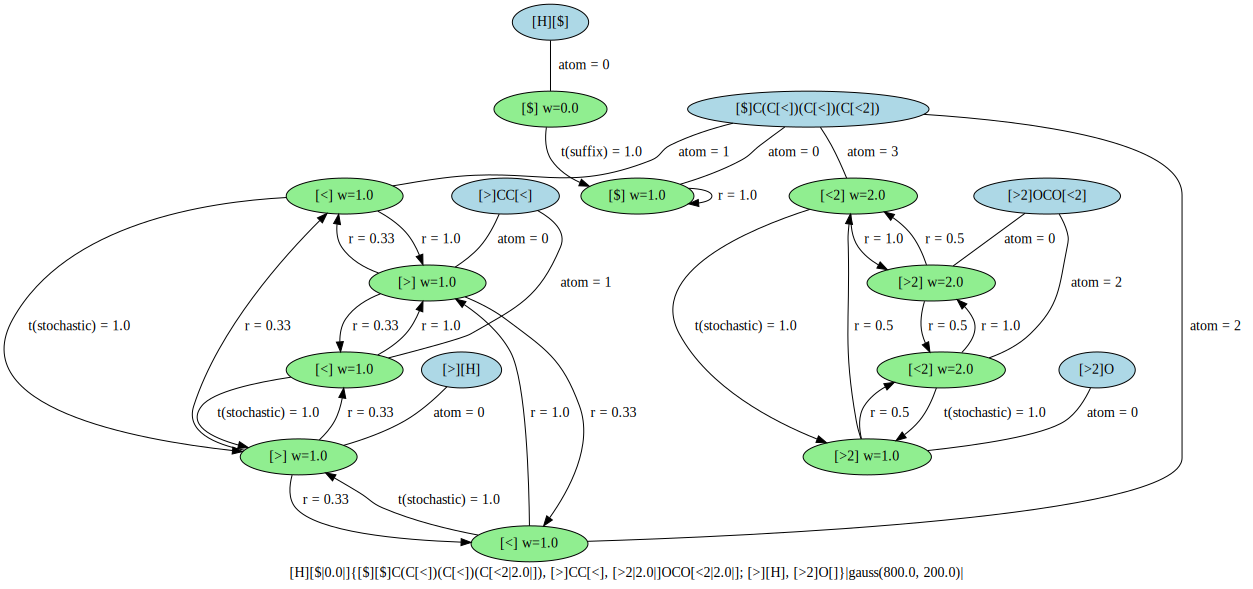

In [58]:
draw_generation_graph(generative_bigSMILES)

### Regulating Arm Molecular Weight

There may be situations where it's necessary to control the molecular weight of each individual arm in a polymer. While this can be accomplished with nested stochastic objects, such functionality isn't supported by this reference implementation. Nevertheless, generative BigSMILES can still perform this task as long as the arms originate from separate atoms.

Consider the following BigSMILES example, where each stochastic object describes a separate arm:

`C{[$] [$]C(CC[<])C[$], [>]CC[<]; [>][H] [$]}CC{[$] [$]C(CC[<])C[$], [>]CC[<]; [>][H] [$]}CC{[$] [$]C(CC[<])C[$], [>]CC[<]; [>][H] [$]}[H]`

To ensure smooth generation with generative BigSMILES, we need to make a few modifications:

1. We assign a molecular weight distribution to each stochastic object, representing an arm.
2. The bond descriptors connecting the arms (and stochastic objects) are distinct from the arms, denoted here by [$] and [>].
3. These bond descriptors are also assigned zero weight, preventing the element from being repeated and ensuring only one arm per stochastic element.
4. We illustrate two variations to achieve this; both work equally well.
5. Finally, we ensure that terminal bond descriptors propagate to the next arm stochastic element.

This approach allows for the independent control of the molecular weight of each arm.


/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


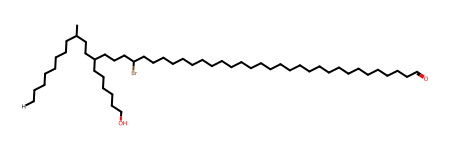

In [59]:
generative_bigSMILES = "C{[$] [$]C(CC[<])C[$2|0|], [>]CC[<]; [>][H] [$2]}|uniform(100,101)|"
generative_bigSMILES += "C{[$] [$]C(CC[<])C[$2|0|], [>]CC[<]; [>]O [$2]}|schulz_zimm(200,150)|"
generative_bigSMILES += "C{[$] [$|0|]C(CC[<])C[$|0|], [>]CC[<]; [>]C(=O) [$]}|gauss(300,30)|[Br]"
draw_molecule(generative_bigSMILES)

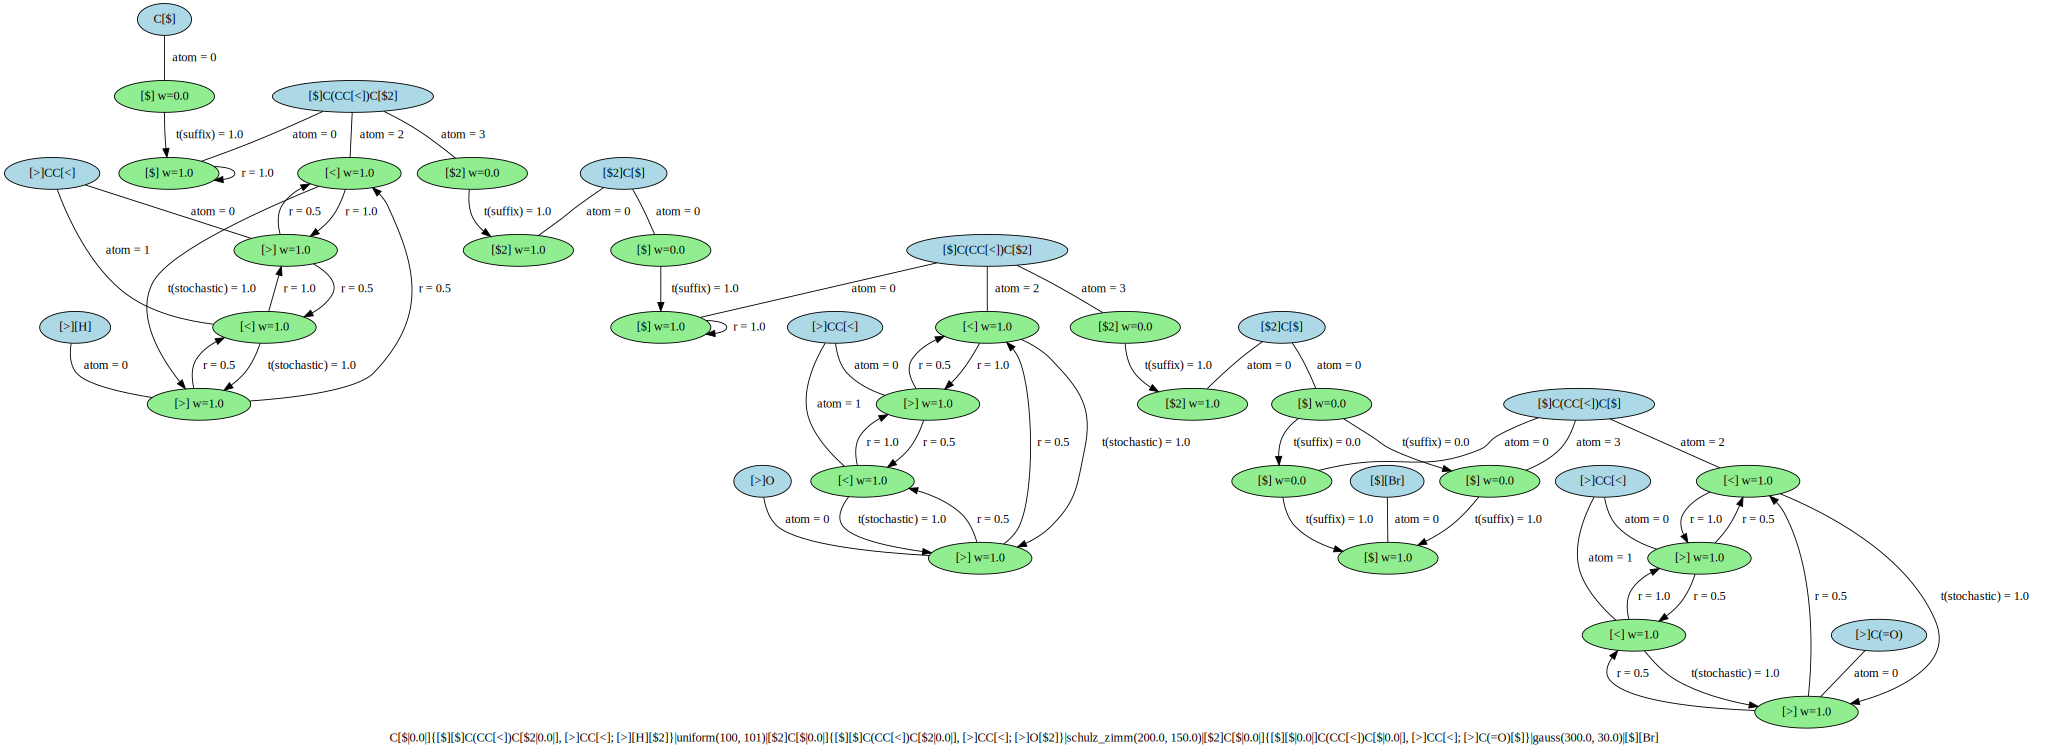

In [60]:
draw_generation_graph(generative_bigSMILES)

## Ring Polymer

A stochastic ring polymer can be represented in BigSMILES using connection notation `1` across a stochastic object, like so: `C1{[>][<]CCO[>][<]}CO1`. Here, the first carbon atom and the last oxygen atom complete the ring with a covalent bond, each labeled with `1`.

This can be replicated in generative BigSMILES: `C1{[>][<]CCO[>][<]}|poisson(1000)|CO1`. However, the current reference implementation doesn't support connection across a stochastic object.

_Note_: The reasoning behind this lack of support is that every SMILES token must be a valid SMILES string for a molecule. Neither the prefix `C1` nor the suffix `CO1` are valid SMILES strings for molecule generation.


## Hyper-Branched Polymer: Poly-Ethylene

The BigSMILES for branched poly-ethylene can be defined as: `C{[$][$]CC([$])[$],[$]CC[$]; [$][H][$]}[H]`.

Generative BigSMILES provides more control. Firstly, a molecular weight distribution, Flory-Schulz in this case, is added:

/home/ludwig/git/bigSMILESgen/src/gbigsmiles/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


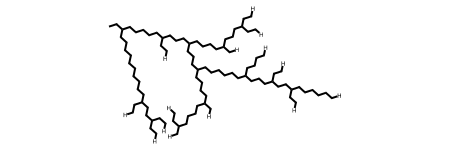

In [61]:
generative_bigSMILES = "C{[$][$]CC(CC[$])(CC[$]),[$]CC[$]; [$][H][$]}|flory_schulz(1e-3)|[H]"
draw_molecule(generative_bigSMILES)

Furthermore, the branch point density can be stochastically controlled via the weights of bond descriptors. In this example, all bond descriptors in a branch point repeat unit are assigned a weight of 1/10. The resulting transition probabilities can be interpreted from the generation graph:

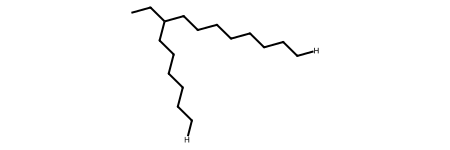

In [62]:
generative_bigSMILES = "C{[$][$|.1|]CC(CC[$|.1|])(CC[$|.1|]),[$]CC[$]; [$][H][$]}|flory_schulz(5e-3)|[H]"
draw_molecule(generative_bigSMILES)

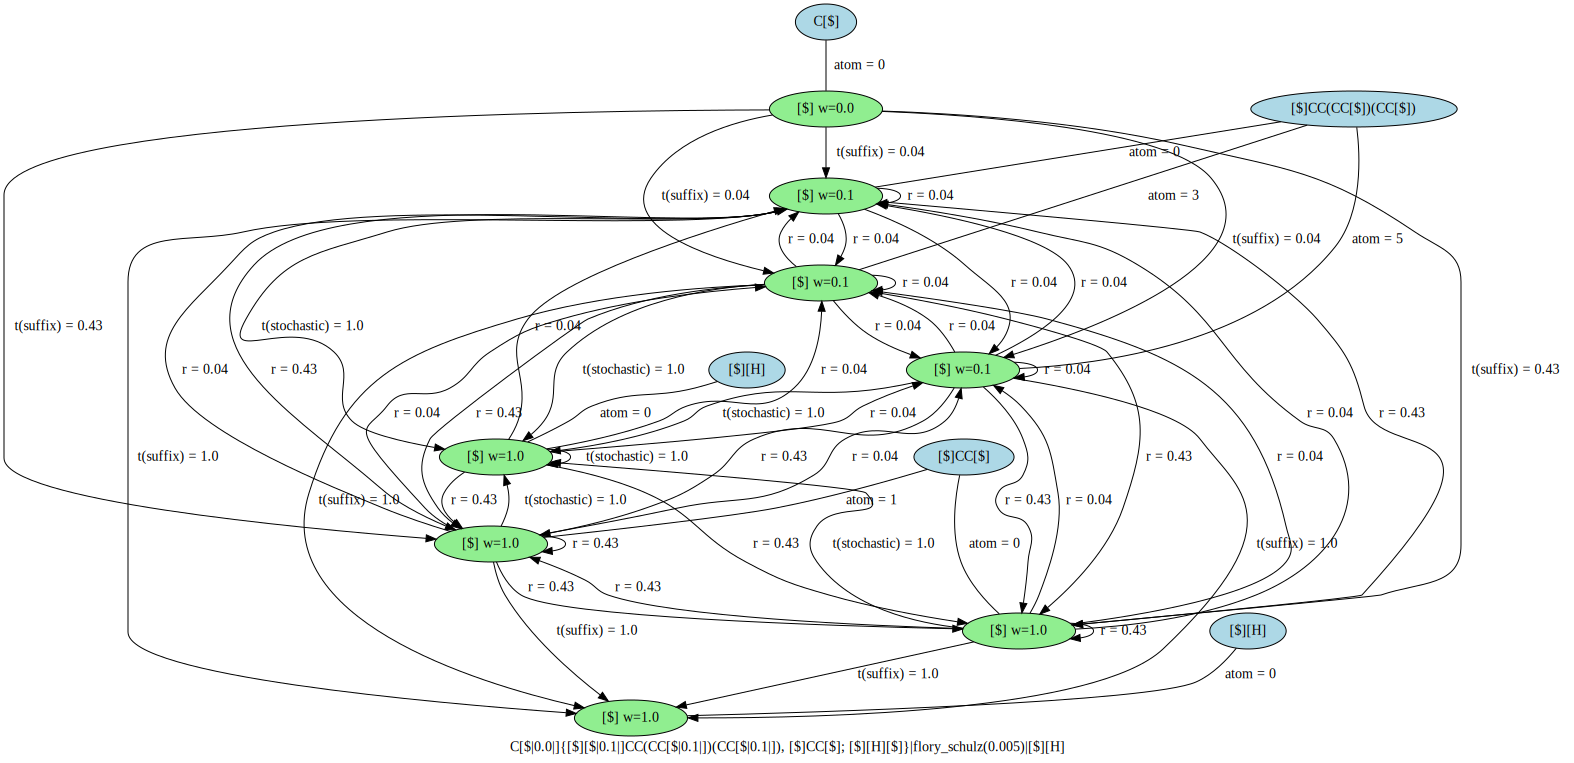

In [63]:
draw_generation_graph(generative_bigSMILES)

## Excluding Internal Loops: Low-Density Polyethylene

Low-density polyethylene can form loops during synthesis. That is, high branching can lead to rings within a single molecule. However, Generative BigSMILES currently doesn't support this. Like cross-linked networks, we believe that spatial considerations should be incorporated into molecule generation, a function beyond the capacity of line notations. In the future, we might consider an extension to the Generative BigSMILES notation to cover this situation. For now, if a polymer ensemble is more restrictively defined with Generative BigSMILES, molecules with loops are always excluded.

## Bond Descriptor ID for Reaction probabilities

The advanced notation allows for a reaction probability to be specified between each of the bond descriptors.
    This is how the ID and weights are assigned:


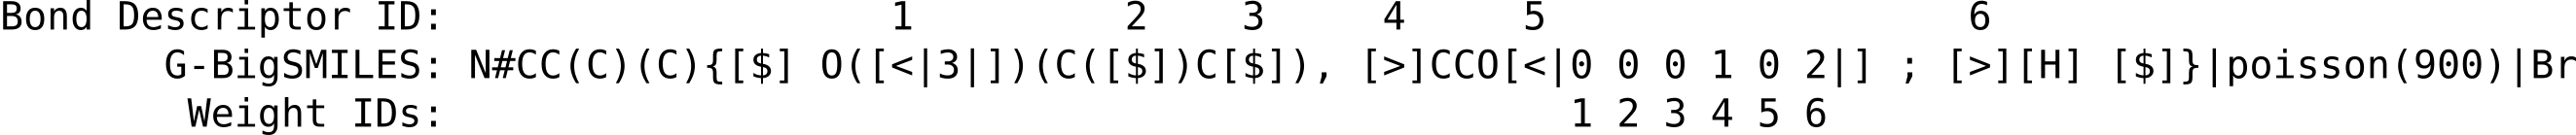

So in this bottle brush scenario, we have a zero weight for the bond descriptors: `1: [<|3|]`, `2:[$]`, `3: [$]`, and `5: [<|0 0 0 1 0 2|]`.
A weight of `1` for the 4th bond descriptor `[>]` and a weight of 2 for the bond descriptor of the end group `6: [>]`.

Note how terminal bond descriptors do not have an ID and IDs for bond descriptors are always only assigned within one stochastic object.

## Validating Molecular Weight

In prior sections, we focused on single molecule examples. Now, we'll ensure that the properties of entire ensembles are also consistent with our expectations. Our starting point is the targeted molecular weight of stochastic entities.

We begin by crafting a function to analyze and visualize the distribution of G-BigSMILES strings. Remember, we're considering full ensembles in this context, necessitating the `gbigsmiles.System` specification along with a molecular weight descriptor. While we showcase the Gaussian distribution for its appealing linear characteristics, the approach—aside from merging two stochastic entities—remains unchanged. Other distributions undergo separate unit testing.

*Note:* Creating complete ensembles significantly extends the execution time compared to single molecule generation. Anticipate each test to span several minutes.

In [64]:
import matplotlib.pyplot as plt

from IPython.display import clear_output

def plot_distribution(bigsmiles, expected_mu, expected_sigma, bins=25):
    # Generate the ensemble of molecules
    bigsmiles_system = gbigsmiles.System(bigsmiles)
    generated_weights = []
    total_weight = 0
    for gen_mol in bigsmiles_system.generator:
        mol_weight = gen_mol.weight
        generated_weights += [mol_weight]
        total_weight += mol_weight
        update_progress(total_weight/bigsmiles_system.system_mass)


    hist, bin_edges = np.histogram(generated_weights, bins=bins, density=True)
    mw = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2

    # Generate the expected mw distribution data
    def gaussian(x, mu, sigma):
        return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2* (x-mu)**2/sigma**2)
    expected = gaussian(mw, expected_mu, expected_sigma)

    # Plot the result
    fig, ax = plt.subplots()
    ax.set_xlabel("Mw")
    ax.set_ylabel("p(Mw)")

    ax.plot(mw, expected, label="expected distribution")
    ax.plot(mw, hist, label="generated distribution")
    ax.legend(loc="best")

    plt.show()
    plt.close(fig)

    # Return the mean squared difference between the expected and actual distribution distributions
    return np.sqrt(np.mean((expected-hist)**2)) * expected_mu

### Simple Linear Polymer

Progress: [####################] 100.1%


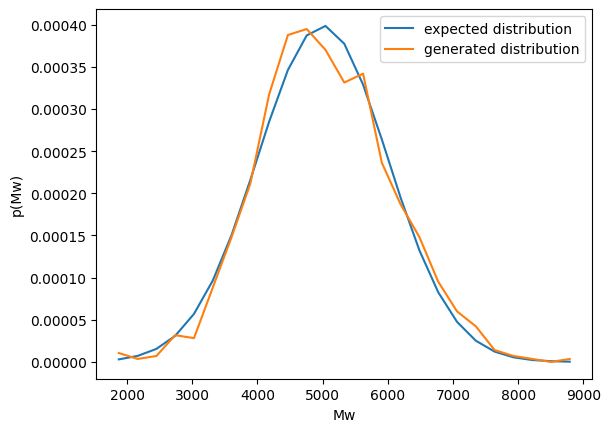

In [65]:
# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    mu = 5e3
    sigma = 1e3
    generative_bigSMILES = "[H]{[>] [<]CC([>])c1ccccc1 [<]}|gauss("+str(mu)+", "+str(sigma)+")|[H].|5e6|"
    normalized_deviation = plot_distribution(generative_bigSMILES, mu, sigma)
    # Let's make sure our expectations are fulfilled (important for automated tests)
    if normalized_deviation > 0.5:
        raise RuntimeError(f"The actual distribution deviates from the expected distribution {normalized_deviation}")

The produced ensemble closely aligns with the anticipated distribution.

### Bottlebrush Structure

Progress: [####################] 100.1%


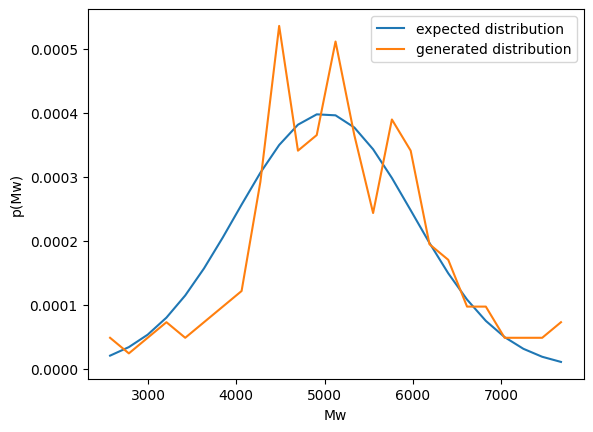

In [66]:
# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    mu = 5e3
    sigma = 1e3
    generative_bigSMILES = "N#CC(C)(C){[$] O([<|3|])(C([$])C[$]), [>]CCO[<|0 0 0 1 0 2|] ; [>][H] [$]}|gauss("+str(mu)+", "+str(sigma)+")|[Br].|1e6|"
    normalized_deviation = plot_distribution(generative_bigSMILES, mu, sigma)
    # Let's make sure our expectations are fulfilled (important for automated tests)
    if normalized_deviation > 0.5:
        raise RuntimeError(f"The actual distribution deviates from the expected distribution {normalized_deviation}")

For this intricate scenario with numerous end groups, the resulting distribution aligns closely with the anticipated one, as foreseen. We utilize a smaller ensemble in this instance due to its elevated computational demand, leading to increased fluctuations.

### Diblock Copolymer: PS-PMMA

Given the linearity of the Gaussian distribution, the combined molecular weight of the two blocks is Gaussian-distributed. Both the mean and variance are sums of their respective blocks' mean and variance.

Progress: [####################] 100.4%


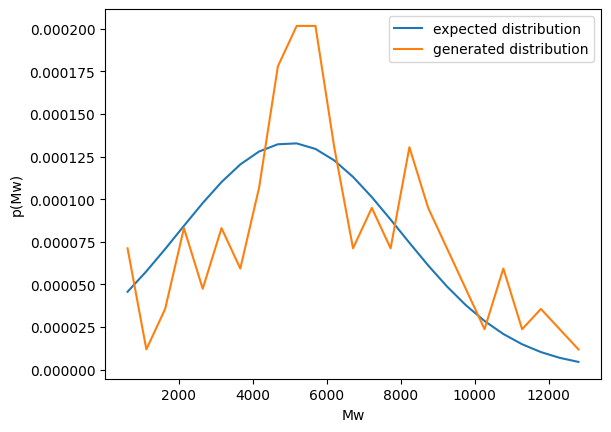

In [67]:
# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    mu_ps = 2e3
    mu_pmma = 3e3
    sigma_ps = 1e3
    sigma_pmma = 2e3
    generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1 [<]}|gauss("+str(mu_ps)+", "+str(sigma_pmma)+")|{[>][<]CC([>])C(=O)OC[<]}|gauss("+str(mu_pmma)+", "+str(sigma_pmma)+")|[Br].|1e6|"

    normalized_deviation = plot_distribution(generative_bigSMILES, mu_ps+mu_pmma, sigma_ps+sigma_pmma)
    # Let's make sure our expectations are fulfilled (important for automated tests)
    if normalized_deviation > 0.5:
        raise RuntimeError(f"The actual distribution deviates from the expected distribution {normalized_deviation}")

Owing to its linear nature, the total molecular weight distribution of the diblock copolymer adheres to the expected distribution derived from combining the molecular weights of the individual blocks.

### Limitation: Self-Terminating Generation

Using list weights, one can dictate a premature termination of generation by assigning a non-zero probability to an end group. In such instances, the resultant molecular weight distribution might not align with the specified distribution in the string. This discrepancy is a recognized limitation, and this example serves as a cautionary note for users.

In our demonstration, there's a 1 in 40 probability that the polymer generation halts prematurely.

Progress: [####################] 100.2%


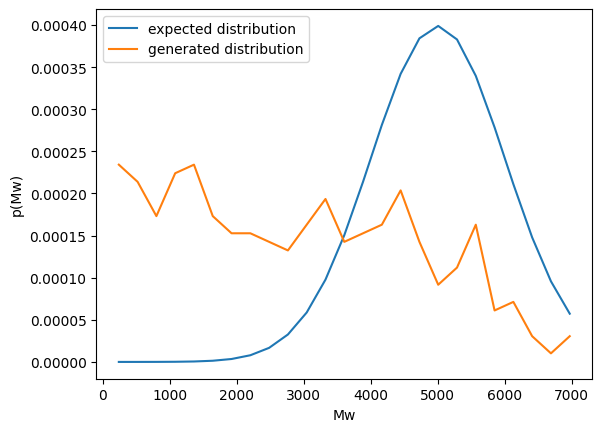

In [68]:
# In testing environments only run on the linux systems:
if IS_LINUX or not TESTING_ENV:
    mu = 5e3
    sigma = 1e3
    generative_bigSMILES = "[H]{[>] [<]CC([>|40 0 1|])c1ccccc1 ; [<][H] []}|gauss("+str(mu)+", "+str(sigma)+")|.|1e6|"
    normalized_deviation = plot_distribution(generative_bigSMILES, mu, sigma)
    # Let's make sure our expectations are fulfilled (important for automated tests)
    if normalized_deviation < 0.5:
        raise RuntimeError(f"We expect the distributions to clearly deviate, which is not the case. {normalized_deviation}")

Upon juxtaposing the distributions, a noticeable divergence is evident. The molecular weight distribution that's generated skews significantly towards lower molecular weights. This is anticipated since the generation can halt prematurely. While the resultant distribution bears resemblance to a geometric distribution, it isn't a precise match. The inherent Gaussian distribution can also interrupt the generation. Consequently, we detect a peak in higher molecular weights, proximate to the expected mean of the Gaussian distribution.

## Stochastic Atom Graphs

When considering G-BigSMILES as graphs, we have several options for graph representation.

### Hierarchical Generation Graph

The first option is the hierarchical generation graph. In this representation, repeating groups, end groups, and connecting groups are depicted as nodes in a graph that illustrates the connections between these molecular fragments. This representation has been previously discussed in the notebook.

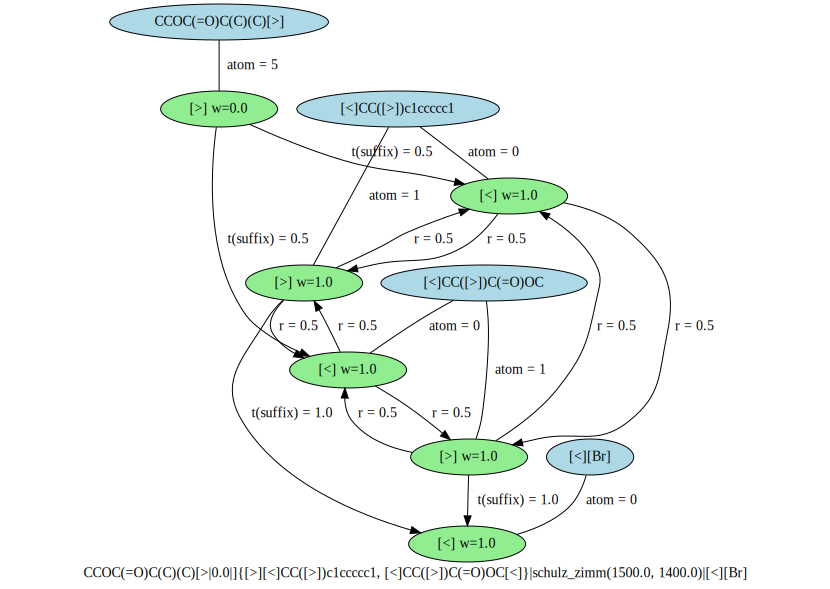

In [69]:
g_big_smi = "CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1, [<]CC([>])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br]"
draw_generation_graph(g_big_smi)

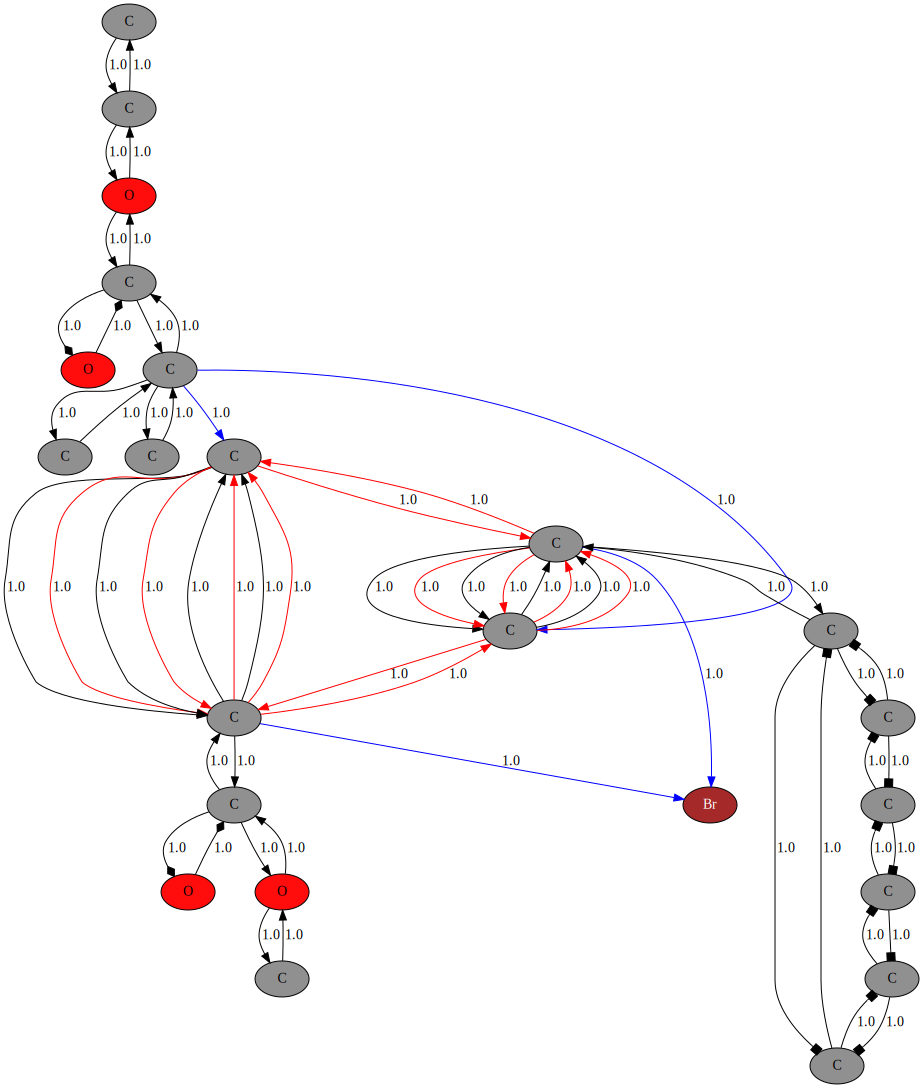

In [70]:
def draw_stochastic_atom_graph(stochastic_atom_graph):
    

    
    graph_dot = gbigsmiles.core.stochastic_atom_graph_to_dot_string(stochastic_atom_graph)

    if pydot:
        pydot_graph = pydot.graph_from_dot_data(graph_dot)[0]
        graph_svg = pydot_graph.create_svg()
        return render_svg(graph_svg)
    else:
        return ''

mol = gbigsmiles.Molecule(g_big_smi)
stochastic_atom_graph = mol.gen_stochastic_atom_graph(expect_schulz_zimm_distribution=True)
draw_stochastic_atom_graph(stochastic_atom_graph)

As we can see, this representation eliminates the need for hierarchy and instead encodes hierarchical information as edge attributes in the graph.

- Black: Connections within a molecular fragment
- Red: Connections between repeat units
- Blue: Connections between stochastic elements
- Arrow: Single bonds
- Box: Aromatic bonds
- Number labels: Probability of bond formation

This transformation makes the graphs slightly more complex, but it enables the use of conventional and well-established graph algorithms, such as graph matching, graph edit distance, and machine learning tools like message passing neural networks.

### Full Atom Graphs

The information contained in the stochastic atom graphs remains complete. We can demonstrate this by using the stochastic atom graph to build a full molecule from the ensemble.

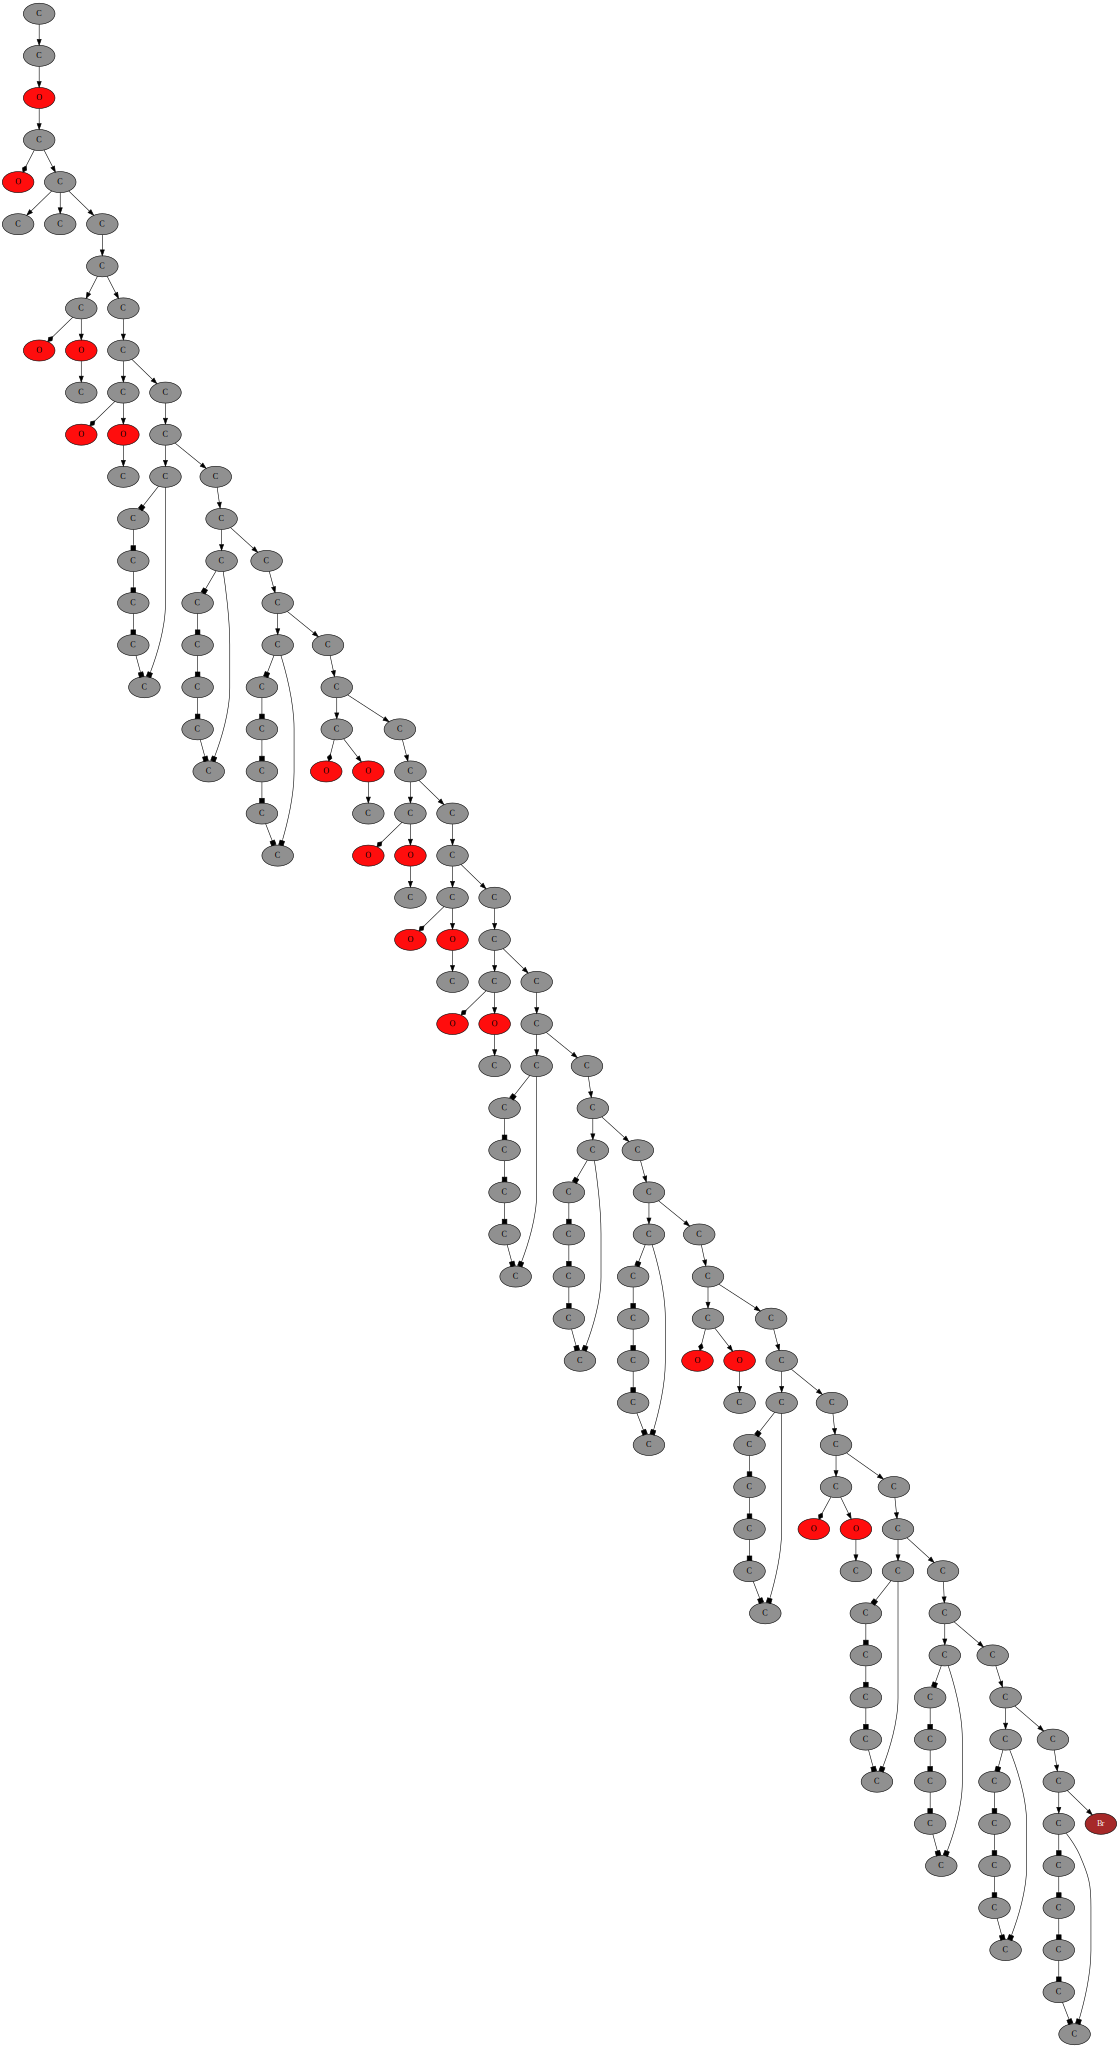

In [71]:
def render_molecule_from_stochastic_atom_graph(stochastic_atom_graph):
    from gbigsmiles.graph_generate import AtomGraph
    full_graph = AtomGraph(stochastic_atom_graph, rng=rng)
    full_graph.generate()
    atom_dot = gbigsmiles.core.molecule_atom_graph_to_dot_string(full_graph)
    if pydot:
        pydot_graph = pydot.graph_from_dot_data(atom_dot)[0]
        graph_svg = pydot_graph.create_svg()
        return render_svg(graph_svg)
    else:
        return ''
render_molecule_from_stochastic_atom_graph(stochastic_atom_graph)

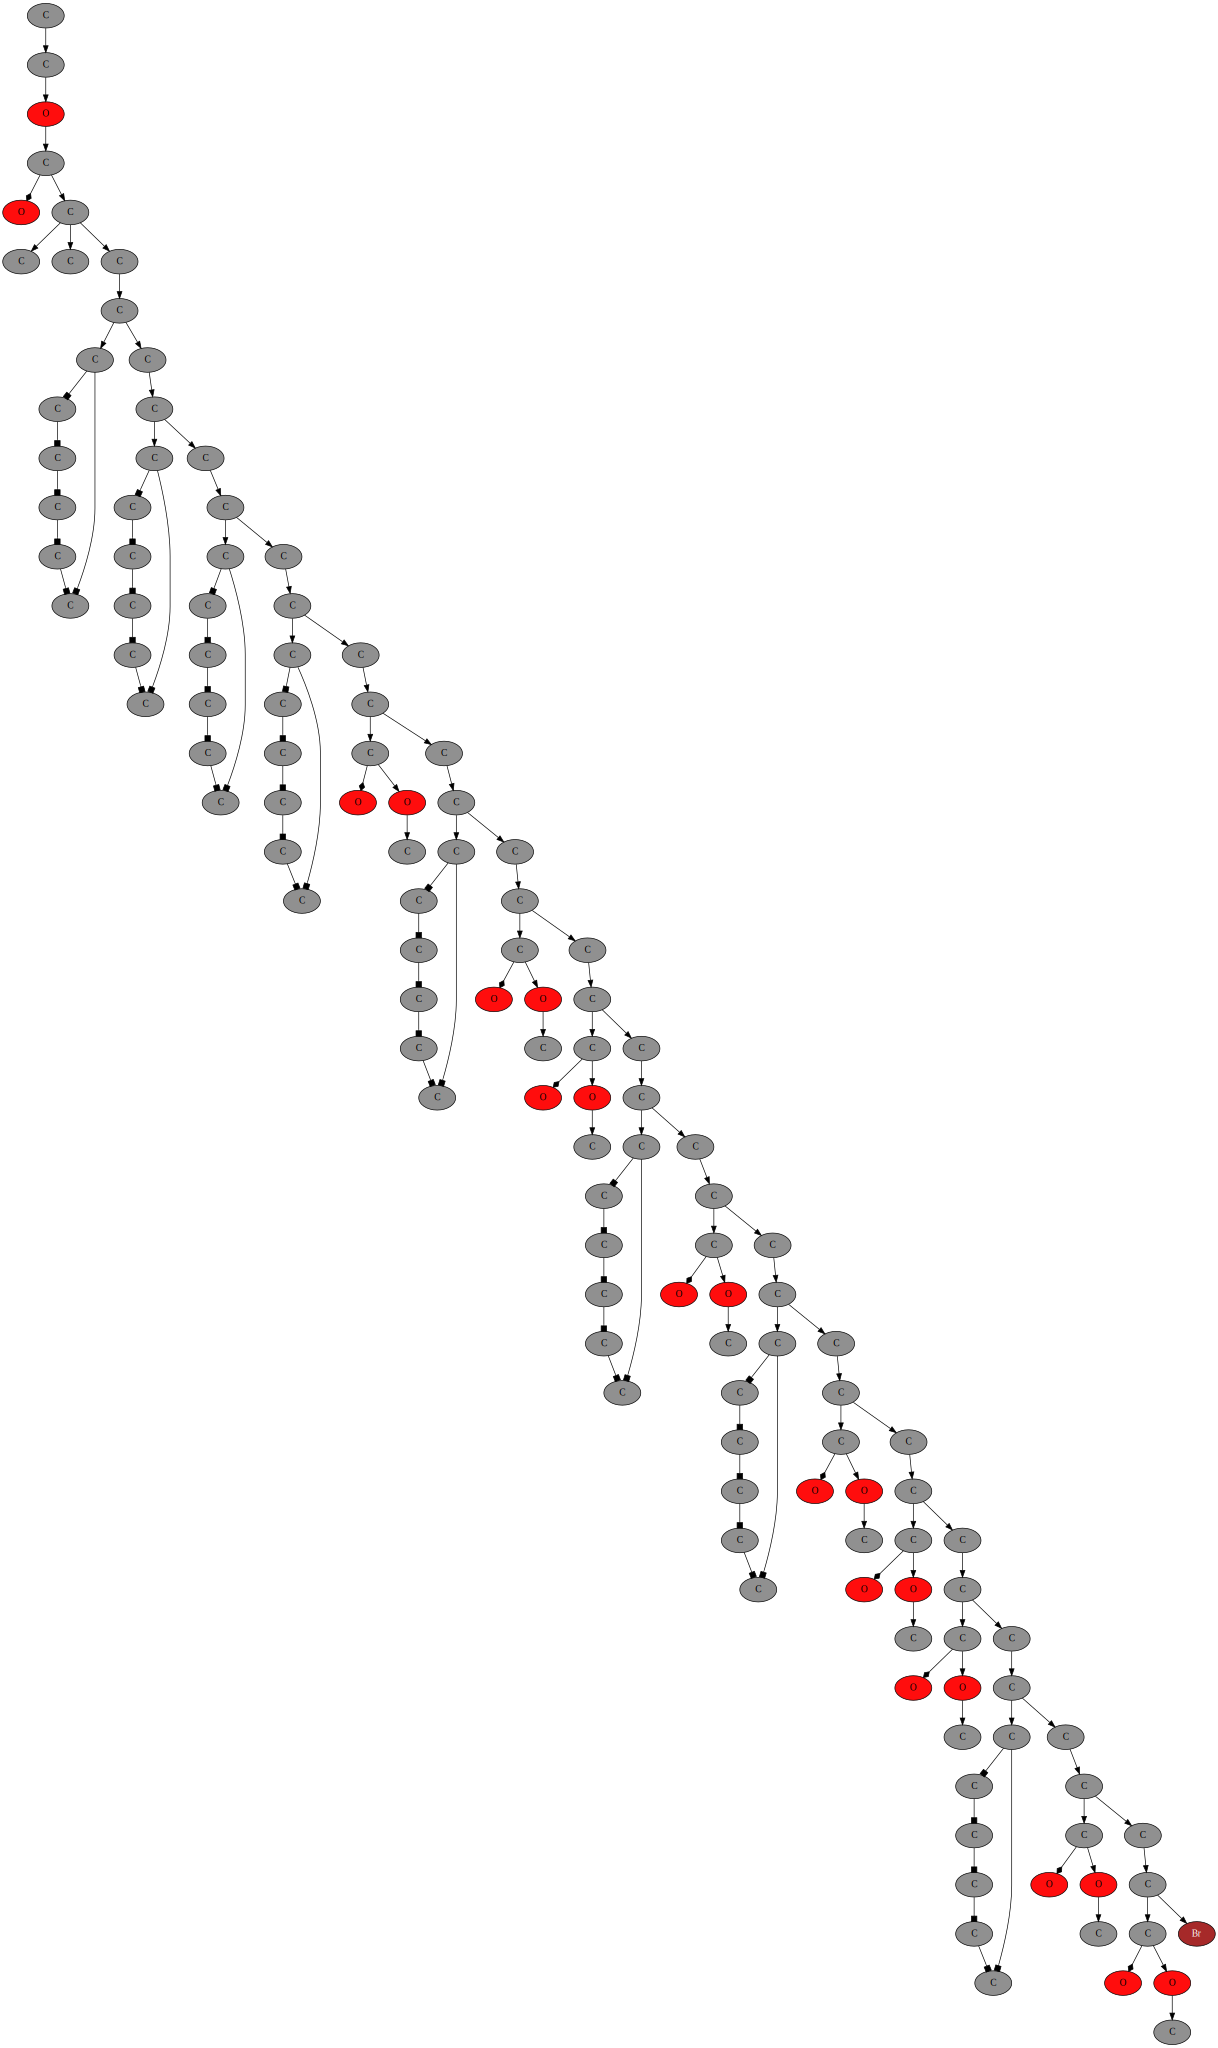

In [72]:
render_molecule_from_stochastic_atom_graph(stochastic_atom_graph)

Just as before, these graphs have too many nodes to be handled efficiently with graph algorithms. Additionally, they differ as they are samples from an ensemble.